# Classifying MBTI Based on Social Media Use
#### ECON 323 003 Quantitative Economic Modelling with Data Science Application

Group Members: Zaya Baatarzaya (45131414) | Kim Tan Palanca (98857568) | Vivian Vu (92958461) | Sophia Zhang (65921389)

# Introduction

Personality is defined as the characteristics and behavior of an individual that encompass their emotional patterns (American Psychology Association, 2022). Over time, many mechanisms and indicators have been discovered that break down the intricacies of a personality into general categories, one of which is the Myers-Briggs Type Indicator (MBTI) test. Isabel Briggs Myers and Katherine Briggs developed this personality instrument to bring true Carl Jung’s theory of personalities having fundamental differences.

The MBTI classification has four main divisions, with two contrasting traits in each. Depending on the characteristics an individual satisfies, a four-letter code that combines one quality from each division will determine the individual’s personality type. The divisions and traits are listed as follows:

**Table 1.** <br>
*Myers-Briggs Type Indicators*</p>


Category  | Traits | Description
------------- | ------------- | -------------
Favorite World  | Introvert (I) or Extrovert (E) |Preference to focus on the outer world or one’s inner world.
Information  | Sensing (S) or Intuition (N) | Preference to focus on and take in basic information or to interpret and add meaning.
Decisions | Thinking (T) or Feeling (F) |Preference to first look at logic and consistency or to first look at the people and special circumstances when making decisions.
Structure | Judging (J) or Perceiving (P) | Preference to get things decided or to stay open to new information and options when dealing with the outside world.

Note. The information in this table is taken from The Myers & Briggs Foundation. (2022, November). MBTI® basics. The Myers & Briggs Foundation. Retrieved April 3, 2023, from https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/ 

Many aspects of one’s behavior determine their personality type, including their writing style (Gupta et al., 2019). With the popularity of social media, where people have the freedom to share their thoughts and stories, many individuals of varying personality types can arise on a single social media platform (Nisha et al., 2021).

The dataset “(MBTI) Myers-Briggs Personality Type Dataset” by user Mitchell J presents data collected from the PersonalityCafe forum, including an individual’s MBTI and their last 50 posts on the platform. The PersonalityCafe forum is a highly interactive online platform where users can share and discuss various topics, though most topics are related to personality psychology. To participate in the discussions, users must create a profile on the platform, to which they would typically include their MBTI type in their profile description. The posts collected for this dataset consist of discussion starters, comments, and replies to other users in various discussion threads. 

Utilizing the techniques learned in the ECON 323 course, this project explores the relationship between Myers Briggs Type Indicators (MBTI) and social media use. <font color='red'>More specifically, to determine the key differences between each trait of each category of the MBTI based on the words used in the social media posts.</font>



# Cleaning

Before performing any analysis, it is critical to import the dataset and any packages used throughout the study. As mentioned in the introduction, the project will manipulate the “(MBTI) Myers-Briggs Personality Type Dataset” by user Mitchell J. Note that we first separated the original data set into two CSV files: one with only the MBTI type and another with only the posts. We then imported the two files into this notebook.

In [1]:
!pip install lxml
!pip install wordcloud
!pip install nltk

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import seaborn as sns

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)

from bs4 import BeautifulSoup
import nltk
import string
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
types = pd.read_csv("mbti_types.csv")
posts = pd.read_csv("mbti_posts.csv")

print(types.head(3))
print(posts.head(3))

   type
0  INFJ
1  ENTP
2  INTP
                                               posts
0  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  'I'm finding the lack of me in these posts ver...
2  'Good one  _____   https://www.youtube.com/wat...


As shown in the output above, all the 50 posts in the `posts` CSV file are stored in one column. For this study, howwever, each nth post of a user will be considered as one variable, meaning that the columns will be labelled as the post number, numbered 0 to 49. Thus, each row in the `posts` CSV file will be seaparated by `"|||"`.

In [3]:
sep_posts = posts['posts'].str.split("\|\|\|", expand = True)

sep_posts.head(3)

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,'http://www.youtube.com/watch?v=qsXHcwe3krw,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,enfp and intj moments https://www.youtube.com...,What has been the most life-changing experienc...,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,May the PerC Experience immerse you.,The last thing my INFJ friend posted on his fa...,Hello ENFJ7. Sorry to hear of your distress. I...,84389 84390 http://wallpaperpassion.com/uplo...,Welcome and stuff.,...,None,None,None,None,None,None,None,None,None,None
1,'I'm finding the lack of me in these posts ver...,Sex can be boring if it's in the same position...,Giving new meaning to 'Game' theory.,Hello *ENTP Grin* That's all it takes. Than w...,This + Lack of Balance and Hand Eye Coordination.,Real IQ test I score 127. Internet IQ tests ar...,You know you're an ENTP when you vanish from a...,http://img188.imageshack.us/img188/6422/6020d1...,http://img.adultdvdtalk.com/813a0c6243814cab84c51,I over think things sometimes. I go by the old...,...,None,None,None,None,None,None,None,None,None,None
2,'Good one _____ https://www.youtube.com/wat...,"Of course, to which I say I know; that's my bl...",Does being absolutely positive that you and yo...,"No, I didn't; thank you for a link!",So-called Ti-Si loop (and it can stem from any...,Have you noticed how peculiar vegetation can b...,The Smiths ‚Äì Never Had No One Ever,I often find myself spotting faces on marble t...,This 5 year-old sentence is an incredibly accu...,I haven't visited this website in the last 3 y...,...,None,None,None,None,None,None,None,None,None,None


Note that there are 89 columns when the expected number of columns should be 50 given that description of the dataset used for this analysis claims to only collect the last 50 posts. After inspecting the `sep_posts` dataframe, some rows had less then 50 posts, while other rows had more then 50. The largest concern with the `sep_posts` dataframe is that there are some empty cells in between the non-empty cells from some rows. An example of this would be row 7257, which is shown below:

In [4]:
sep_posts.iloc[7257][0:60]

0     'This is great and makes a lot of sense, I fee...
1                                I laugh in my sleep :P
2     I would go back to earlier this year so that I...
3     can I just say, this is such an INTJ thread it...
4     it's been non existent, but now im just starti...
5     This is really interesting, I'm definitely a N...
6     Buddy the Elf Chris             - Where Dreams...
7     Well my cognitive function results were pretty...
8     cue5c I know how you feel. I'm in a similar si...
9     I loveeeee German, I'm fluent and was even abl...
10    I really understand what you guys are talking ...
11    I'm REALLY good at reading other people when i...
12               This guy's channel is so helpful! haha
13    Lets just say that over the last year I might ...
14                  I would definitely be a Cockatoo :D
15    I don't think you're personality can change, I...
16    Your Cognitive Functions: Extroverted Intuitio...
17                                              

To mitigate this issue, the empty cells of each row will be dropped and the remaining non-empty rows will shift to fill in the empty spaces.

In [5]:
def shift(row):
    row = row.dropna()
    row = pd.Series(row.values)
    return row

In [6]:
sep_posts = sep_posts.apply(lambda x: x.str.strip()).replace('', np.nan).dropna(how='all', axis=1)
sep_posts2 = sep_posts.apply(shift, axis = 1)

It should also be noted that because the posts were all initially compiled into one string, there is a opening apostrophe and a closing apostrophe in the first and last post of each row, respectively. To ensure that these will not hinder the data analysis, the characters will be removed from their respective cells. 

In [7]:
def remove_first_apostrophe(s):
    if s[0] == "'":
        post = s[1:]
    else:
        post = s
    return post

In [8]:
sep_posts2[0] = sep_posts2[0].apply(remove_first_apostrophe)
sep_posts2.iloc[:, -1] = sep_posts2.iloc[:, -1].apply(lambda x: x[:-1] if isinstance(x, str) else x)

Lastly, the two files--`types` and `sep_posts2`-- will concatenate into one dataframe using the `pd.concat` function.

In [9]:
data = pd.concat([types, sep_posts2], axis=1)
data

,type,0,1,2,3,4,5,6,7,8,...,49,50,51,52,53,54,55,56,57,58
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,enfp and intj moments https://www.youtube.com...,What has been the most life-changing experienc...,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,May the PerC Experience immerse you.,The last thing my INFJ friend posted on his fa...,Hello ENFJ7. Sorry to hear of your distress. I...,84389 84390 http://wallpaperpassion.com/uplo...,...,Move to the Denver area and start a new life f...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENTP,I'm finding the lack of me in these posts very...,Sex can be boring if it's in the same position...,Giving new meaning to 'Game' theory.,Hello *ENTP Grin* That's all it takes. Than w...,This + Lack of Balance and Hand Eye Coordination.,Real IQ test I score 127. Internet IQ tests ar...,You know you're an ENTP when you vanish from a...,http://img188.imageshack.us/img188/6422/6020d1...,http://img.adultdvdtalk.com/813a0c6243814cab84c51,...,Psychologist don't keep me around long enough ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,INTP,Good one _____ https://www.youtube.com/watc...,"Of course, to which I say I know; that's my bl...",Does being absolutely positive that you and yo...,"No, I didn't; thank you for a link!",So-called Ti-Si loop (and it can stem from any...,Have you noticed how peculiar vegetation can b...,The Smiths ‚Äì Never Had No One Ever,I often find myself spotting faces on marble t...,This 5 year-old sentence is an incredibly accu...,...,ISTP? http://www.youtube.com/watch?v=7ghqoYx...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,INTJ,"Dear INTP, I enjoyed our conversation the ot...","Dear ENTJ sub, Long time no see. Sincerely,...",None of them. All other types hurt in deep exi...,Probably a sliding scale that depends on indiv...,Draco Malfoy also. I'd say he's either 358 or ...,"I'm either 358 or 385, though in which stackin...",I'm not particularly introverted or extraverte...,"Dear Type 9 INFP, Your absolute admiration of...",2% still means about 1/50 people. I've probabl...,...,Lol.',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENTJ,You're fired.,That's another silly misconception. That appro...,But guys... he REALLY wants to go on a super-d...,Never mind. Just go on permanent vacation.,Two months? I wouldn't be crazy about the idea...,Lol. Its not like our views were unsolicited. ...,Sometimes I just really like impoverished rap ...,I probably would have lost it too. His stonewa...,I would have just taken the project and gave t...,...,The brevity of my posts is because you don't t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8670,ISFP,https://www.youtube.com/watch?v=t8edHB_h908,IxFP just because I always think of cats as Fi...,Especially on websites that have become a have...,I'm such a nerd. I've been learning Dutch on D...,Duolingo is the shit! Oh my god I love this XD,Right wingers do this because they lack politi...,"I doubt it, but if they are real then I hope t...",I would agree that both are likely related to ...,Both Nazi Germany and the Soviet Union were ex...,...,"Also, what moderate even means changes dependi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8671,ENFP,So...if this thread already exists someplace e...,Ooops...I guess I didn't look too hard because...,"So, this came up in the You Know You're An ENF...",I know that I liked UP. :D,I choose feeding myself joy over beating mysel...,[QUOTE=Pucca;2951774]I've never seen it.:shock...,That's hilarious. hahaha I used to pretend I h...,WOOO! I'd love to be the TARDIS! :D,"This is from my signature (actually, just look...",...,My lovelife is nonexistant. Recently (basica...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8672,INTP,So many questions when i do these things. I w...,I worked in a brewery for a couple years here....,I am going to summon the great and powerful mr...,This thread is obviously about the textbook de...,St

Despite applying the `shift` function to the `sep_posts` dataframe, there are still more than 50 columns in total. This being said, it will now be assumed that the data collection implies an average of the last 50 posts were collected from each user, with some having less than 50 posts and others having more. 

# Data Descriptions

Given the large number of observations in the dataset, it is beneficial first to understand the distribution of how many posts are given for each MBTI type to provide understanding of the representation of each MBTI type and any possible uneven distribution when concluding the analysis. As the focus of the study is on the key differences of each trait of the four categories, a distribution of each quality will be provided. It should be noted that many of the posts will overlap in the count as each MBTI type is a combination of one of the two traits in each category.

In [10]:
traits = ["I", "E", "S", "N", "T", "F", "J", "P"]
counts = {}
for letter in traits:
    count = data['type'].str.count(letter).sum()
    counts[letter] = count

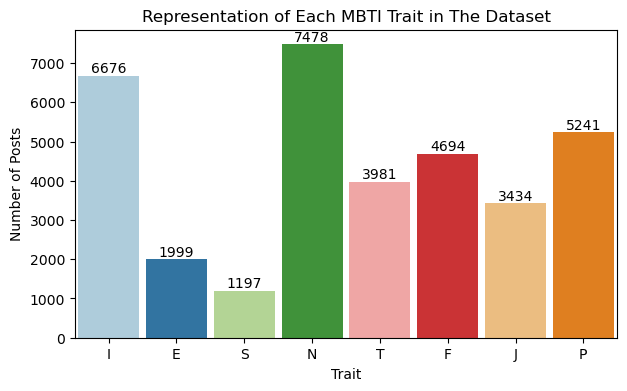

In [11]:
plt.subplots(figsize= (7,4))
ax = sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette = 'Paired', width = 0.9)
ax.bar_label(ax.containers[0], labels = counts.values())
plt.title("Representation of Each MBTI Trait in The Dataset")
plt.xlabel("Trait")
plt.ylabel("Number of Posts")

plt.show()

## Word Counts of Posts from Each MBTI

The code below defines a function that will count the words of each post in the data, excluding spaces and punctuations.

The summary statistics of the word counts for the posts of each MBTI, along with a boxplot visualization are generated to provide a description on the average and range of the length of a post of each MBTI.

In [20]:
def favorite_world (data):
    fav_world = []
    for i, r in data.iterrows():
        first_letter = r['type'][0]
        if first_letter == 'I':
            fav_world.append('I')
        elif first_letter == 'E':
            fav_world.append('E')
    return fav_world

def information(data):
    info = []
    for i, r in data.iterrows():
        second_letter = r['type'][1]
        if second_letter == 'S':
            info.append('S')
        elif second_letter == 'N':
            info.append('N')
    return info

def decision (data):
    decision = []
    for i, r in data.iterrows():
        third_letter = r['type'][2]
        if third_letter == 'T':
            decision.append('T')
        elif third_letter == 'F':
            decision.append('F')
    return decision

def structure (data):
    structure = []
    for i, r in data.iterrows():
        fourth_letter = r['type'][3]
        if fourth_letter == 'J':
            structure.append('J')
        elif fourth_letter == 'P':
            structure.append('P')
    return structure

In [21]:
data["favorite world"] = favorite_world(data)
data["information"] = information(data)
data["decision"] = decision(data)
data["structure"] = structure(data)

In [24]:
data_posts = data.drop(columns = ["type", "favorite world", "information", "decision", "structure"])

In [25]:
def word_count(dp):
    total_count=[]
    for n in range(len(dp)):
        posts_list = [x for x in dp.iloc[n]]
        word_count = 0
        for p in posts_list:
            if isinstance(p, str):
                soup = BeautifulSoup(p, 'html.parser')
                text = soup.get_text()
                words = word_tokenize(text)
                word_count += len(words)
        total_count += [word_count]
    return total_count


In [26]:
data["Word Count"] = word_count(data_posts)

/tmp/ipykernel_658/3071079642.py:8: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(p, 'html.parser')
/tmp/ipykernel_658/3071079642.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(p, 'html.parser')


In [27]:
data_word_count = data.drop(columns = [x for x in range(59)])
data_word_count = data_word_count.drop(columns = "type")

data_word_count

,Word Count,favorite world,information,decision,structure
0,790,I,N,F,J
1,1465,E,N,T,P
2,1067,I,N,T,P
3,1350,I,N,T,J
4,1211,E,N,T,J
...,...,...,...,...,...
8670,1015,I,S,F,P
8671,1726,E,N,F,P
8672,1219,I,N,T,P
8673,2084,I,N,F,P


In [28]:
summary_stats = pd.DataFrame()  
cols = ["favorite world", "information", "decision", "structure"]

for col in cols:
    group = data_word_count.groupby(col)
    for val, group_data in group:
        trait = val[0]
        summary_stats[f"{trait} word count"] = group_data.describe()
        

In [31]:
summary_stats

,E word count,I word count,N word count,S word count,F word count,T word count,J word count,P word count
count,1999.000000,6676.000000,7478.000000,1197.000000,4694.000000,3981.000000,3434.000000,5241.000000
mean,1535.116558,1529.829239,1539.625970,1477.456140,1562.461014,1494.008038,1548.440012,1519.651784
std,353.502682,362.819386,354.230594,394.578051,361.699692,355.975957,362.158030,359.287380
min,46.000000,11.000000,11.000000,84.000000,11.000000,80.000000,148.000000,11.000000
25%,1335.500000,1322.750000,1340.000000,1227.000000,1359.000000,1283.000000,1350.000000,1309.000000
50%,1591.000000,1593.500000,1600.000000,1546.000000,1629.000000,1548.000000,1621.000000,1576.000000
75%,1790.500000,1798.000000,1799.000000,1765.000000,1830.000000,1762.000000,1817.000000,1783.000000
max,2272.000000,2231.000000,2272.000000,2188.000000,2272.000000,2213.000000,2217.000000,2272.000000


Text(0.5, 1.0, 'Boxplots of Word Counts of Social Media Posts Based on MBTI Trait')

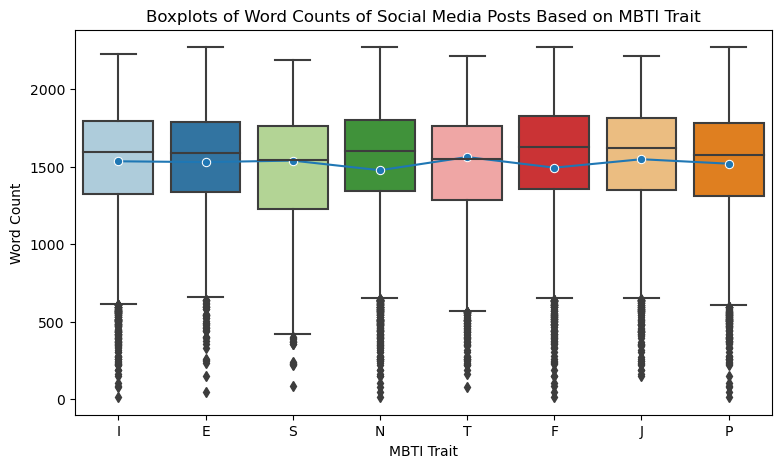

In [38]:
plt.subplots(figsize= (9,5))
box_fw = sns.boxplot(data=data_word_count, x="favorite world", y="Word Count", order = traits, palette = 'Paired')
box_in = sns.boxplot(data=data_word_count, x="information", y="Word Count", order = traits, palette = 'Paired')
box_de = sns.boxplot(data=data_word_count, x="decision", y="Word Count", order = traits, palette = 'Paired')
box_st = sns.boxplot(data=data_word_count, x="structure", y="Word Count", order = traits, palette = 'Paired')
line = sns.lineplot(x=traits, y=summary_stats.loc["mean"], sort = traits, errorbar = None, marker = "o", estimator = 'mean', legend = True)
plt.xlabel("MBTI Trait")
plt.ylabel("Word Count")
plt.title("Boxplots of Word Counts of Social Media Posts Based on MBTI Trait")
           

### Word Clouds

When determining the most commond words for each MBTI, it is essential that the chosen words have variation to provide a clearer distnction between the MBTI types. This being said, words such as "the," "a," "an," "is," and "to" will be excluded in the analysis. Words in each post will also automatically be converted to their dictonary form for simplicity.

In [ ]:
columns = range(0, 59)
data_wc = data.copy()
data_wc['posts'] = data_wc[columns].stack().groupby(level=0).agg(' '.join)
data_wc.drop(columns, axis=1) 


data_wc['Favourite World'] = data_wc['type'].apply(lambda x: 'Extrovert' if x[0] == 'E' else 'Introvert')
data_wc['Information'] = data_wc['type'].apply(lambda x: 'Intuitive' if x[1] == 'N' else 'Sensing')
data_wc['Decisions'] = data_wc['type'].apply(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
data_wc['Structure'] = data_wc['type'].apply(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')


def gen_wc(posts, title):
    wordcloud = WordCloud(background_color='white').generate(posts)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

E_I = data_wc.groupby('Favourite World')['posts'].apply(' '.join).reset_index()
N_S = data_wc.groupby('Information')['posts'].apply(' '.join).reset_index()
T_F = data_wc.groupby('Decisions')['posts'].apply(' '.join).reset_index()
J_P = data_wc.groupby('Structure')['posts'].apply(' '.join).reset_index()


# Wordcloud for each group 
for i, title in enumerate(E_I['Favourite World']):
    posts = E_I.iloc[i,1]
    gen_wc(posts, title)








In [ ]:
for i, title in enumerate(N_S['Information']):
    posts = N_S.iloc[i,1]
    gen_wc(posts, title)

In [ ]:
for i, title in enumerate(T_F['Decisions']):
    posts = T_F.iloc[i,1]
    gen_wc(posts, title)

In [ ]:
for i, title in enumerate(J_P['Structure']):
    posts = J_P.iloc[i,1]
    gen_wc(posts, title)

In [98]:
# stopwords = set(nltk.corpus.stopwords.words('english'))
# stopwords = stopwords.union(set(string.punctuation))

# wnl = nltk.WordNetLemmatizer()

AttributeError: 'float' object has no attribute 'punctuation'

A newly defined function `text_prep` is then created, compiling the functions set in the cell above, that will clean, tokenize, remove stopwords, and lemmatize the words in each post. 

In [97]:
# def text_prep(txt):
#     soup = BeautifulSoup(txt, "lxml")
#     [s.extract() for s in soup('style')]
#     txt=soup.text
#     txt = txt.lower()
#     tokens = [token for token in nltk.tokenize.word_tokenize(txt)]
#     tokens = [token for token in tokens if not token in stopwords]
#     tokens = [wnl.lemmatize(token) for token in tokens]
#     if (len(tokens)==0):
#         tokens = ["EMPTYSTRING"]
#     return(tokens)

In this report, the ten most common words used by each MBTI will be chosen. These words will then be displayed on a bar graph to determine their frequencies in posts, along with a word cloud for further visualization.

KeyError: 'Column not found: posts'

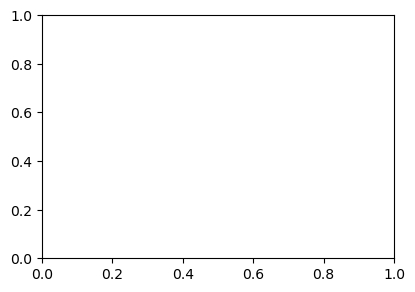

In [99]:
# fig = plt.figure(figsize=(10, 60))
# spec = fig.add_gridspec(ncols=2, nrows=16)
# for i, t in enumerate(mbti):
#     ax0 = fig.add_subplot(spec[i, 0])
#     group = pd.Series(' '.join(group_data['posts'].get_group(f"{t}")).lower().split()).to_string(index = False)
#     group = text_prep(group)
#     group_str = ' '.join(group)
#     wordcloud = WordCloud(collocations = False, background_color = 'white').generate(group_str)
#     ax0.imshow(wordcloud, interpolation='bilinear')
#     plt.axis("off")

#     ax1 = fig.add_subplot(spec[i, 1])
#     post_dict = wordcloud.process_text(group_str)
#     word_freq={y: s for y, s in sorted(post_dict.items(),reverse=True, key=lambda item: item[1])}
#     dist = pd.DataFrame(list(word_freq.items())[:10])
#     dist.columns = ["Words", "Count"]
#     ax1.bar(x = dist["Words"], height = dist["Count"])
#     ax1.tick_params(axis='x', labelrotation = 45)
#     ax1.set_xlabel(f"Top 10 Most Used Words by {t} Types")
#     ax1.set_ylabel("Count")
#     plt.tight_layout()
#     plt.title(f"{t}", x = 0, y=1.05, fontsize = 15)
    
# plt.show()

# Analysis

### Dividing testing and training

In [100]:
train, test = model_selection.train_test_split(data, test_size=0.3, random_state = 301)

#### Visualizing the Training Data Distribution

In [101]:
train

,type,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,Word Count
3938,ISTP,The ISTPs quiet moments didnt seem to bother y...,Dr. Hill - INTJ The Stranger - INTP,Chris - ENTP Josh - ENFJ Sam - ISFP Mike - ES...,I've witnessed the dynamics of these two types...,"Give me 30 minutes, a gun, an apple and a box ...",Who dislikes ENTJs?? Only if your gullible or ...,^^^ This! I once used my BB gun on a huge brow...,"Use my bare hands. Skin to carapace, guts n al...",I dont get it. Violence??,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1242
5687,INTP,ok thank you!,hmm so 2 gods? that's interesting. Seems probl...,". So much like 5L you are unable, for this e...",How do you know that? I qualified it as a fict...,Argument from authority fallacy. Ones credenti...,My preference is irrelevant. I personally do n...,And this is precisely why you need an authorit...,Faith is unreliable. That‚Äôs why I prefer a r...,"I am an atheist, and yet my life is not empty ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1533
3331,ISTP,:wink:,I'm trying,I feel like this thread needs more pictures,I just wanted to insert myself into this threa...,Please do and you're welcome Sent from my i...,is it July yet?,and yes we are willing to approve said underwear,do not over plan it! bring sexy underwear! ha...,Keep in mind everyone is different and this is...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,834
7116,INTP,"Alright, I'm just bored. So I thought up a gam...","I had a overall happy childhood, I was inquisi...",These are all from when I was in elementary sc...,Depends how they try to help. I can understand...,I have a very strong Fe when it comes to under...,"Yes, this sounds like what I am experiencing. ...","Serious question, have any of you INTPs experi...","Hey guys, I've been hoping that some of you co...","I went into university loving science, but was...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014
1425,INFP,Golden,Radiohead,Yeahhhhh !!!! Congratulations :D :carrot:,.,energetic to frustrated,wow :excitement:,Put out fire because i would probably try to t...,Chocolate,Energised and ready to fight the day,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2365,INFP,"Not married, but I would to either elope or ha...","I'm assertive when it comes to my ideas, moral...","I'm sorry, I feel you. My father is also an es...",The reason why most 9's mistype is because enn...,You e8 entj father sounds just like my e8 estj...,"Goodness, this is literally my childhood. Exce...","I find it so easy to be around intps, they're ...","Weirdly enough, I don't mind it terribly. I gu...",Librarylady Are you a 9 perchance?,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960
4331,INTJ,"So my sick, stiff and introverted self started...",I second this so much! My ISFP boyfriend has d...,My ISFP boyfriend and I :). 440162440178 ...,I'm INTJ and I've been dating an ISFP for 5 mo...,I've been interested in an intp in the past (f...,I've been romantically involved with an INTJ i...,255506,9483894839948409484194842 I am genderfluid and...,.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1423
3730,INTP,My son and I doing our mad faces at his birth ...,I'm from NC as well 35 minutes west of Charlot...,Love it,Naturally ESFJ's why I have no idea they just ...,If your a male and have come to realize that y...,No doubt I find it funny when someone tries to...,This crap 187386,Love the eyes.,Lol yes the phone. :wink:,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1052
1604,ENTP,Any place with craft beers. And sometimes musi...,So I dunno if you could read it from my self d...,I'm often intimidated by wild bears.,I've found that just asking how they're doing ...,"Little late to the party, and a little late se...",The most sacrificial thing I will ever do is d...,Occasionally I need a diaper.,I am actually your guardian angel speaking to ...,Do you do butt stuff?,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1607


In [102]:
group_train = train.groupby('type')

n_train = []
for x in mbti:
    num_rows = len(group_train.get_group(f"{x}"))
    n_train += [num_rows]
    
n_train_obs = pd.DataFrame([np.array(mbti), np.array(n_train)]).T
n_train_obs.columns = ["type", "n obeservations"]

Text(0.5, 1.0, 'Representation of Each MBTI in Training Data')

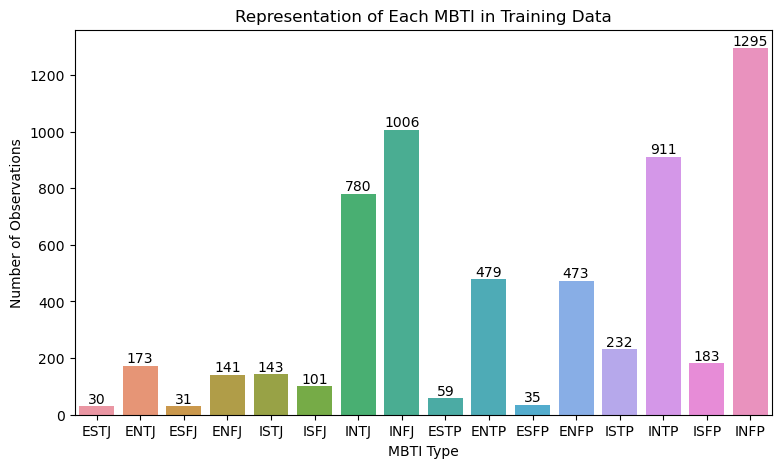

In [103]:
plt.subplots(figsize= (9,5))
ax = sns.countplot(train, x = "type", order = mbti)
ax.bar_label(ax.containers[0], labels = n_train)
plt.xlabel("MBTI Type")
plt.ylabel("Number of Observations")
plt.title("Representation of Each MBTI in Training Data")